# Convolution, a smart way to do superpostion

IHE, transient groundwater

Olsthoorn, 2019-01-04

Convolution is a smart way to do superpostion, in space as well as in time. But mostlu we'll use it with respect to time. It is used to obtain the head at some time due to arbitrarily varying input in the past.

Imagine that the past input in adjacent pieces, each constant during a given time unit $d\tau$. Then the result at $t$ due to intput happening between $t-(\tau - d\tau)$ and $t - \tau$ in the past can be computed by super position

$$ s = p(t - (\tau + d\tau)) \left( R_s(\tau + d\tau) - R_s(\tau) \right)$$

where $p(t - (\tau + d\tau) $ is the constant $p$ between $t - (\tau + d\tau)$ and $t - \tau$ en where $R_s(..)$ is the so-called step response, i.e. the response to $p=1$ for $t>0$ and $p=0$ for $t<=0$ 

To obtain the total response of the input we have, when we assume all $d\tau$ are constant, i.e. the time axis is divided in equal time intervals $d\tau$: 

$$ s = \sum _{i=0} ^\infty \left\{p(t - (i+1) d\tau) \left( R_s((i+1) d\tau) - R_s(i d\tau) \right) \right\} $$


The interesting thing is, that most analytical solutions are in fact step responses. Like the solution for a sudden head change and the solution for a well that starts extracting at a constant rate at $t=0$.

For example the Theis solution for a well in a uniform aquifer of infinite extent, when devided by $Q$ of with $Q=1$ for that matter is a step response

$$ R_s(\tau) = \frac {s(r, \tau)} Q  = \frac 1 {4 \pi kD} W(u), \,\,\,\, u = \frac {r^2 S} {4 kD \tau} $$

So with $W(-)$ the exponential $\mathtt{exp1}(..)$ we have for a Theis well

$$ R_s(\tau) = \frac {\mathtt{exp1}(\frac {r^2 S} {4 kD \tau})} {4 \pi kD} $$

which is simpel enough.

Let's for convenience call the second factor in the sum expression the block response $B(\tau)$

Then

$$ s = \sum _{i=0} ^\infty \left\{p(t - (i+1) d\tau) \, B_r(i \, \tau, d\tau) \right\} $$


This expression can be viewed graphically bin alining the $\tau$ axis backward from time $t$ along the time axis of $p(t)$ and then multiplying the corresponding values and summing the result.

This summation (convolution / filtering) is readily done with `scipy.signal.lfilter(..)`.

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import exp1
from scipy.signal import lfilter

In [112]:
# aquifer data

S = 0.001 # [-]
kD = 600 # m2/d
r = 1000. # m

# time step length
dtau = 1

# length of time series taken as long as the length of the block response
tau = np.arange(1, 100, dtau)

# step response
Step = np.hstack((0, exp1(r**2 * S /(4 * kD * tau)) / (4 * np.pi * kD)))

# compute block response as difference of two step responses
B = Step[1:] - Step[:-1]

# Time series data (extaction)
# Well 1 extraction time series
Q1   = -700 * (np.random.rand(len(B)) + 0.5)

# Well 2 extraction time series
Q2   = Q1.copy()

# modify extraction time series of well 1 to a simpler one to more easily interprete the result
Q1[:] = -800; Q1[:80] = -100; Q1[:30] = -500

# time axes, arbitrary, one can use dates as well
time = 100. + tau

## Convolution by means of `scipy.signal.lfilter(..)`

In [113]:
# compute the time series response to each well at the given r
s1 = lfilter(B, 1, Q1)
s2 = lfilter(B, 1, Q2)

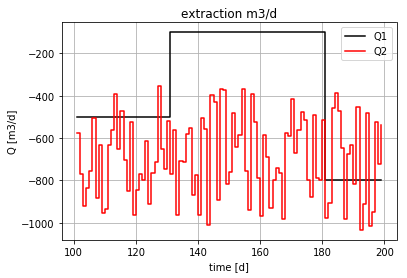

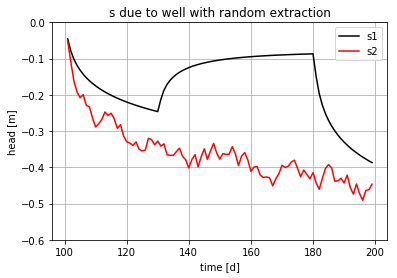

In [114]:
# show graph of the input
plt.title('extraction m3/d')
plt.xlabel('time [d]')
plt.ylabel('Q [m3/d]')
plt.step(time, Q1, 'k', label='Q1', where='post')
plt.step(time, Q2, 'r', label='Q2', where='post')
plt.grid()
plt.legend()
plt.show()

# show the result, i.e. the head change caused by the varying extraction
plt.title('s due to well with random extraction')
plt.xlabel('time [d]')
plt.ylabel('head [m]')
plt.ylim((-0.6, 0))
plt.grid()
plt.plot(time, s1, 'k', label='s1')
plt.plot(time, s2, 'r', label='s2')
plt.legend()
plt.show()

## Compare the result for well s1 with regular superposition

We can obtain the same results by means of regular superpostion. We'll show this on the hand of the input of well Q1, which is less random, and so easier to compare.

In [115]:
# extract the times that the flow changes and the change of the extractions themselves
sw = np.hstack((True, np.diff(Q1) != 0)) # bool array, where True is the change of flow
Q3 = Q1[sw]     # Get the flow changes at these times
swt = time[sw]  # Get the actual times at which the flow changes
dQ  = np.hstack((Q3[0], np.diff(Q3))) # Compute the flow changes themselves

# Just print out the above to see what has been obtained in each step.

What follows next is ordinary superposition in time

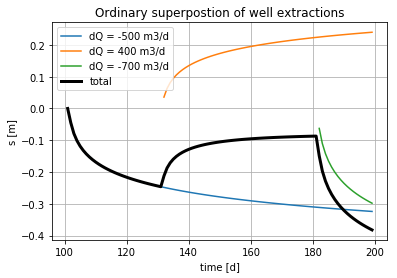

In [116]:
plt.title("Ordinary superpostion of well extractions")
plt.xlabel('time [d]')
plt.ylabel('s [m]')
plt.grid()

s = np.zeros_like(time)

# loop over the switch times and the flow changes
for st, dq in zip(swt, dQ): 
    I = time > st   # select the time points that are later than the current switch times

    # compute the head changes for these times
    s_ = dq /(4 * np.pi * kD) * exp1(r**2 * S / (4 * kD * (time[I] - st)))
    plt.plot(time[I], s_, label='dQ = {:.0f} m3/d'.format(dq))

    # add them to the total head changes
    s[I] += s_
    
plt.plot(time, s, 'k', lw=3, label='total')
plt.legend()
plt.show()

As can be seen by comparing the graphs, the superposition yields the same results as the convolution, however, the convolution is more straight forward and simpler if the extraction varies truly randomly.

## Bibliography

Olsthoorn, T.N. (2008) Do a bit more with convolution. Groundwater Journal. Vol. 46 No. 1, 13-22